# AI Coursework: Predicting Dementia Status from MRI Brain Images

Using a convolution neural network model

## Install Dependencies

In [5]:
# conda activate tf - for specific environment

In [6]:
!pip install scikit-learn
!pip install numpy
!pip install matplotlib
!pip install opencv-python

In [7]:
import os

In [8]:
import numpy as np

In [9]:
import matplotlib.pyplot as plt

In [10]:
import cv2

In [11]:
import tensorflow as tf
tf.__version__

'2.18.0'

In [12]:
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split

## Import Images

In [13]:
#Define the path for the images of the brain MRI scans
path = '/Users/maisievarcoe/Desktop/AI/Coursework/images'

In [14]:
#Define paths for each impairment level: none, mild and moderate and count images in each
NoImpairment = os.path.join(path,'NoImpairment')
MildImpairment = os.path.join(path,'MildImpairment')
ModerateImpairment = os.path.join(path,'ModerateImpairment')

print("Number of MRIs with no impairment", len(os.listdir(NoImpairment)))
print("Number of MRIs with mild impairment", len(os.listdir(MildImpairment)))
print("Number of MRIs with moderate impairment", len(os.listdir(ModerateImpairment)))


Number of MRIs with no impairment 2560
Number of MRIs with mild impairment 1792
Number of MRIs with moderate impairment 725


In [52]:
#Define function to load the images
def load_images(directories, n_images=900000):
    images = [] #stores image arrays
    labels = [] #stores class label for each image

    #loop through directories and assign labels 
    for label, sub_dir in enumerate(directories):
        file_list = os.listdir(sub_dir) 
        num_loaded = 0
        
        #loop through every file in folder with progress bar 
        for file_name in tqdm(
            file_list,
            desc=f"Loading {os.path.basename(sub_dir)}",
            unit="img",
            total=len(file_list)
        ):

            if num_loaded >= n_images: 
                break    

            #load each image, if not image = None    
            img_path = os.path.join(sub_dir, file_name)
            img = cv2.imread(img_path)
            
            if img is not None:
                #load as greyscale
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                img = cv2.resize(img, (224, 224))  # Resizes images to consistent shape

                #append processed image and its label
                images.append(img)
                labels.append(label)  # 0 for Uninfected 1 for Parasitized
                num_loaded += 1
    return np.array(images), np.array(labels)


In [53]:
#Load the images
images, labels = load_images([NoImpairment, MildImpairment, ModerateImpairment])
print(len(images),"images were loaded!", len(labels),"labels were loaded!")
print(Counter(labels)) #checks all images are loaded

Loading ModerateImpairment: 100%|████████████████████████████████████████████| 725/725 [00:00<00:00, 2421.94img/s]


5076 images were loaded! 5076 labels were loaded!
Counter({np.int64(0): 2560, np.int64(1): 1792, np.int64(2): 724})


In [54]:
images.shape #total images loaded, image height, image width

(5076, 224, 224)

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

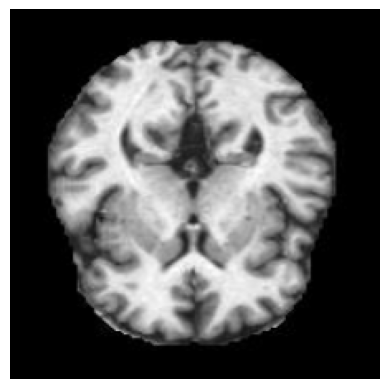

In [58]:
plt.imshow(images[500], cmap='gray')
plt.axis('off')

## Normalise Pixels

The image data range from 0-255 so pixel normalisation changes the range to 0-1.

In [59]:
images=images/255

In [62]:
np.max(images[600]) 

np.float64(1.0)

In [64]:
np.mean(images[600]) 

np.float64(0.30430453431372545)

## Image Augumentation 

In [83]:
! pip install pillow
from PIL import Image

## Train the Model

Split the data into a training set and a test set to train the model on the different classes and test the model's prediction accuracy. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=142)

In [66]:
y_train[190:250]

array([0, 1, 2, 1, 2, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 2, 1, 2,
       0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 2, 1, 1, 0, 0, 2, 0, 2, 1, 2, 2, 0, 0, 0, 2])

In [67]:
print('Dataset splits %s' % Counter(y_train))

Dataset splits Counter({np.int64(0): 2032, np.int64(1): 1436, np.int64(2): 592})


In [68]:
print('Dataset splits %s' % Counter(y_test))

Dataset splits Counter({np.int64(0): 528, np.int64(1): 356, np.int64(2): 132})


Turn the categorical classes into numerical binary 

In [69]:
#one-hot-encoding for training set
y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=3)
#for test set
y_test_ohe= tf.keras.utils.to_categorical(y_test, num_classes=3)

In [72]:
y_test_ohe[195:200]

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

## Define the Convolutional Neural Network Model

Define the shape of the image and labels, as well as input shape (colour).

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Flatten, Dense, Rescaling

# Define the CNN model
# Here we are using colour images so the dimensions are 150,150,3 rather than 150,150,1
# We define a series of sequential layers consisting of convolution layers(2d) and pooling layers
# Notice how the number of nodes within a layer are multiples of 2 - this more efficient for the optimiser
# Finally we flatten the data and pass into a fully-connected(dense) layer and then into the output layer
# The final activation function is a sigmoid function. We could have used a softmax function(with dense(2) outputs) - either would work.
model = Sequential( [
 Input(shape=(224,224,1)),
 #Rescaling(1./255),   # Rescale the colour to be between 0 and 1  - we have already done this in load_images function
 Conv2D(32, (3, 3), activation='relu'), # Use 30 filters with a 3x3 kernel
 MaxPooling2D(pool_size=(2, 2)),
 Conv2D(64, (3, 3), activation='relu'), # Increase number of filters
 MaxPooling2D(pool_size=(2, 2)),
 Conv2D(128, (3, 3), activation='relu'), # Increase number of filters
 MaxPooling2D(pool_size=(2, 2)),
 Flatten(),
 Dense(512, activation='relu'),  # Put into a dense layer size
 Dense(1, activation='sigmoid')  # Gives probability between 0 and 1
] )

## Define the Running of the Model

In [74]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [75]:
# Print the model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,033 (169.36 MB)

 Trainable params: 44,396,033 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

## Fit and Train the Model

In [80]:
from tensorflow.keras.callbacks import EarlyStopping

#early stopping 
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(x=X_train, y=y_train, batch_size=100,
                      epochs=30, shuffle=True,
                      validation_split=0.2, callbacks=[early_stop])


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.5012 - loss: 0.0000e+00 - val_accuracy: 0.4975 - val_loss: 0.0000e+00
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.5012 - loss: 0.0000e+00 - val_accuracy: 0.4975 - val_loss: 0.0000e+00
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.5012 - loss: 0.0000e+00 - val_accuracy: 0.4975 - val_loss: 0.0000e+00
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.5012 - loss: 0.0000e+00 - val_accuracy: 0.4975 - val_loss: 0.0000e+00
Epoch 5/30
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - accuracy: 0.5100 - loss: 0.0000e+00

KeyboardInterrupt: 

In [77]:
epochs = history.epoch

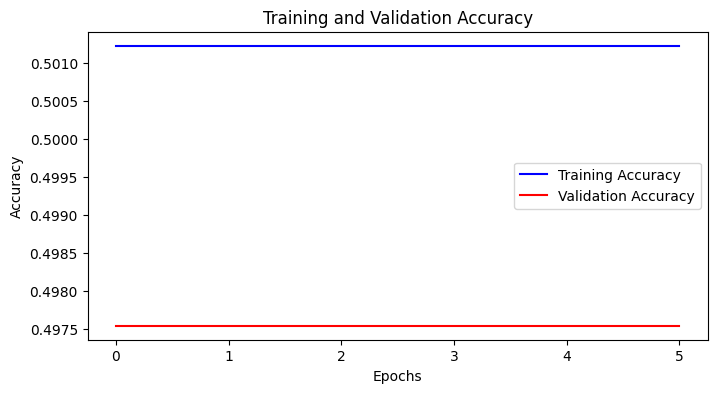

In [78]:
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

# If the validation accuracy or loss differ significantly from the training, this is evidence of overfitting
plt.figure(figsize=(8, 4))
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

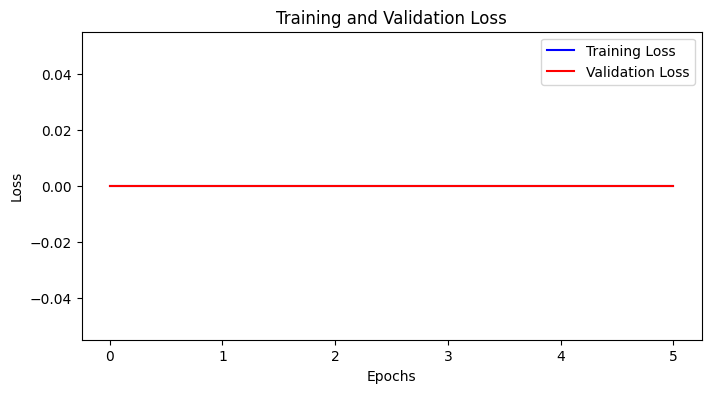

In [79]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
